In [2]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

## Helper functions

In [128]:

def create_animation(images):
    fig = plt.figure()
    ims = []

    for image in images:
        im = plt.imshow(image, animated=True);
        ims.append([im])
    plt.close()

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000);

    return ani

def get_hyperparamaters():
    digits = 3
    gamma = round(np.random.uniform(0.9, 0.99), digits)
    lr = round(np.random.uniform(0.1, 0.5), digits)
    epsilon = round(np.random.uniform(0.1, 0.5), digits)
    return gamma, lr, epsilon

In [129]:
# print gym environment information
env = gym.make('CartPole-v1', render_mode="rgb_array")
print('observation space:', env.observation_space)
print('action space:', env.action_space)


observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


In [119]:
state_space = 4 # number of states
action_space = 2 # number of possible actions

def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

In [120]:


def Q_learning(q_table, bins, episodes = 5000, gamma = 0.9, lr = 0.2, timestep = 100, epsilon = 0.2):
    
    steps = 0
    results = []
    pbar = tqdm(range(1,episodes+1))
    for episode in pbar:
        steps += 1 
        env.reset() # initial observation
        current_state = Discrete(env.reset()[0],bins)
      
        score = 0
        done = False
        solved = False  
        while not done:

            if np.random.uniform(0,1) < epsilon: 
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
                
            observation, reward, done,truncated, info = env.step(action)
            next_state = Discrete(observation,bins)
            score += reward

            if done or score > 500:
                results.append(score)
                break


            max_future_q = np.max(q_table[next_state])
            current_q = q_table[current_state+(action,)]
            new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
            q_table[current_state+(action,)] = new_q
            current_state = next_state

            steps +=1
            if episode % timestep == 0: pbar.set_description(f"Average results for the last {timestep} steps: {np.mean(results[-timestep:])}")
    return results

## Hyperparameter search

Here we search over random combinations of our hyperparameters to find the best combination.

We also keep track the different scores so we can plot the distribution of scores later.

In [122]:
q_table, bins= Qtable(state_space, action_space)

final_hyperparameters = None
best_iteration = None
scores = []
hyperparameters = []
for iteration in range(15):
    gamma, lr, epsilon = get_hyperparamaters()
    q_table, bins= Qtable(state_space, action_space)
    results = Q_learning(q_table, bins, episodes = 1000, gamma = gamma, lr = lr, timestep = 100, epsilon = epsilon)
    scores.append(results)
    hyperparameters.append((gamma, lr, epsilon))
    average_results = np.mean(results)
    if final_hyperparameters is None or average_results > final_hyperparameters[1]:
        final_hyperparameters = ((gamma, lr, epsilon), average_results)
        best_iteration = iteration
        print(f"updating final_hyperparameters to {final_hyperparameters[0]} on iteration {iteration}")
        print(f"Current best average score: {final_hyperparameters[1]}")



Average results for the last 100 steps: 93.0: 100%|██████████| 1000/1000 [00:02<00:00, 432.07it/s]             


updating final_hyperparameters to (0.945, 0.384, 0.128) on iteration 0
Current best average score: 76.421


Average results for the last 100 steps: 118.53: 100%|██████████| 1000/1000 [00:02<00:00, 392.66it/s]


updating final_hyperparameters to (0.918, 0.464, 0.114) on iteration 2
Current best average score: 80.334


Average results for the last 100 steps: 108.13: 100%|██████████| 1000/1000 [00:02<00:00, 418.86it/s]          


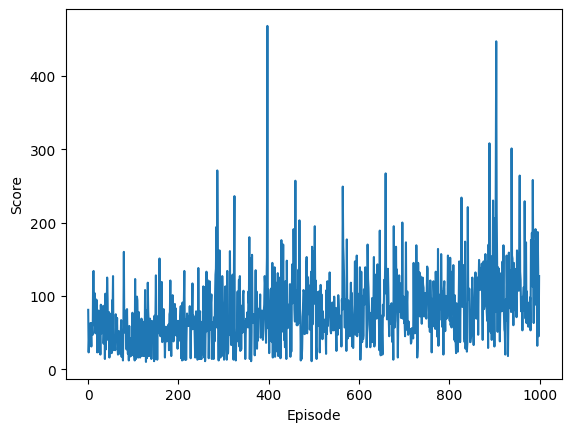

In [123]:
# plot a line graph of the results

plt.plot(scores[best_iteration])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()


## Plotting the distribution of scores

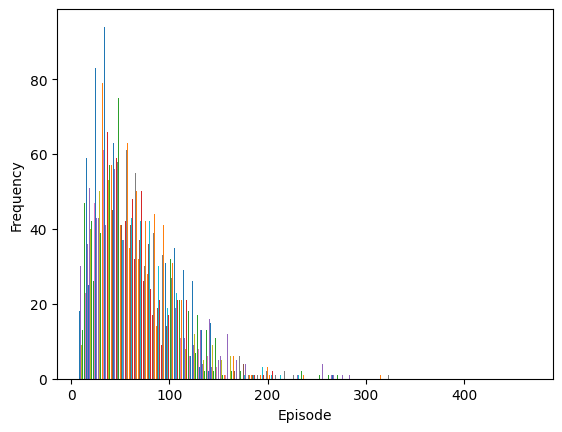

In [124]:

plt.hist(scores, bins=100)
plt.xlabel('Episode')
plt.ylabel('Frequency')
plt.show()

# Training for max score
Now we have searched for good hyperparameters, we can train our agent for the maximum score.

In [125]:
gamma,lr, epsilon = final_hyperparameters[0]
q_table, bins= Qtable(state_space, action_space)

results = Q_learning(q_table, bins, episodes = 10000, gamma = gamma, lr = lr, epsilon = epsilon, timestep = 1000)

Average results for the last 1000 steps: 190.579: 100%|██████████| 10000/10000 [00:35<00:00, 281.17it/s]          


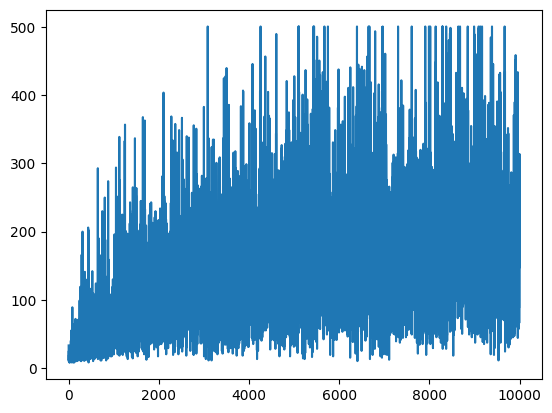

In [126]:
plt.plot(results)

## Conclusion
It's not really necessary to search for optimal hyperparameters, but it's a good exercise to get familiar with running training loops for these kinds of models in a structured way.

In this case we got a decent result with our optimised hyperparameters, but it's not guaranteed that we will get the same result every time we run the search.

I actually found simply choosing the hyperparameters manually to be the best way to get good results.
